In [1]:
import numpy as np
import cv2
import torch
import time

from PIL import Image
from mmcv.cnn import fuse_conv_bn
from mmpose.apis import init_pose_model, inference_bottom_up_pose_model
from apis.inference import vis_det_result, vis_pose_result

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#matplotlib.use('TKAgg')
print(matplotlib.get_backend())

module://ipykernel.pylab.backend_inline


(720, 1280, 3)


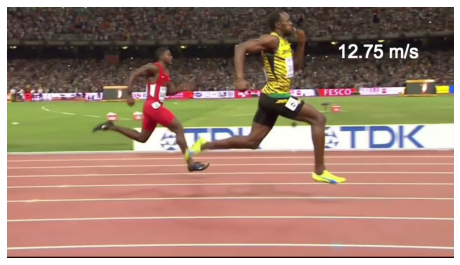

In [3]:
img = np.array(Image.open('images/run.jpg'))
print(img.shape)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off');

# BottomUp method

In [4]:
from mmpose.apis import inference_bottom_up_pose_model

## Model

In [5]:
udp_model = init_pose_model(
    config = 'configs/pose/bottom_up/udp/coco/higher_hrnet48_coco_512x512_udp.py',
    checkpoint = 'https://download.openmmlab.com/mmpose/bottom_up/higher_hrnet48_coco_512x512_udp-7cad61ef_20210222.pth',
    device = 'cuda'
)

udp_model = fuse_conv_bn(udp_model)

Use load_from_http loader


## Result

In [17]:
pose_result, _ = inference_bottom_up_pose_model(model=udp_model, img_or_path=img)

vis = vis_pose_result(model=udp_model, img=img, result=pose_result)

plt.figure(figsize=(10, 10))
plt.imshow(vis)
plt.axis('off')
plt.show()

#cv2.imwrite('visual_result/udp_higher-hrnet48_fully-opt.jpg', img=cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))

NameError: name 'udp_model' is not defined

# TopDown Method

In [4]:
from mmpose.apis import inference_top_down_pose_model
from mmdet.apis import  init_detector
from mmdet.apis import inference_detector

In [5]:
yolo_model = init_detector(
    config = 'configs/detection/yolo/yolov3_d53_mstrain-608_273e_coco.py',
    checkpoint = 'http://download.openmmlab.com/mmdetection/v2.0/yolo/yolov3_d53_mstrain-608_273e_coco/yolov3_d53_mstrain-608_273e_coco-139f5633.pth',
    device='cuda:0'
)

yolo_model = fuse_conv_bn(yolo_model)

next(yolo_model.parameters()).get_device()

Use load_from_http loader


0

In [6]:
print(len(yolo_model.CLASSES))

80


In [7]:
"""def process_mmdet_results(mmdet_results, score_thr=0.3, cat_id=0):
    #Process mmdet results, and return a list of bboxes.
    #:param mmdet_results:
    #:param cat_id: category id (default: 0 for human)
    #:return: a list of detected bounding boxes
    
    if isinstance(mmdet_results, tuple):
        det_results = mmdet_results[0]
    else:
        det_results = mmdet_results

    bboxes = det_results[cat_id]

    person_results = []
    for bbox in bboxes:
        if bbox[-1] < score_thr: continue
        person = {}
        person['bbox'] = bbox
        person_results.append(person)

    return person_results
"""

"def process_mmdet_results(mmdet_results, score_thr=0.3, cat_id=0):\n    #Process mmdet results, and return a list of bboxes.\n    #:param mmdet_results:\n    #:param cat_id: category id (default: 0 for human)\n    #:return: a list of detected bounding boxes\n    \n    if isinstance(mmdet_results, tuple):\n        det_results = mmdet_results[0]\n    else:\n        det_results = mmdet_results\n\n    bboxes = det_results[cat_id]\n\n    person_results = []\n    for bbox in bboxes:\n        if bbox[-1] < score_thr: continue\n        person = {}\n        person['bbox'] = bbox\n        person_results.append(person)\n\n    return person_results\n"

In [8]:
def process_mmdet_results(mmdet_results, cat_id=0):
    """Process mmdet results, and return a list of bboxes.
    :param mmdet_results:
    :param cat_id: category id (default: 0 for human)
    :return: a list of detected bounding boxes
    """
    if isinstance(mmdet_results, tuple):
        det_results = mmdet_results[0]
    else:
        det_results = mmdet_results

    bboxes = det_results[cat_id]

    person_results = []
    for bbox in bboxes:
        person = {}
        person['bbox'] = bbox
        person_results.append(person)

    return person_results

In [9]:
s = time.time()
out =  inference_detector(model=yolo_model, imgs=img)
print(time.time()-s)

s = time.time()
pre_out = process_mmdet_results(out)
print(time.time() - s)

/home/nami-labs/git-clones/mmdetection/mmdet/datasets/utils.py:64: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
0.4994516372680664
9.202957153320312e-05


0.0013194084167480469


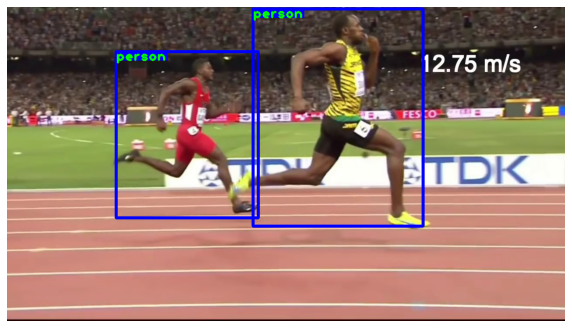

In [10]:
s = time.time()

img_ = vis_det_result(img=img, results=out, score_thr=0.3, classes=yolo_model.CLASSES)

print(time.time() - s)

plt.figure(figsize=(10, 10))
plt.imshow(img_)
plt.axis('off');

In [11]:
pose_model = init_pose_model(
    config = 'configs/pose/top_down/darkpose/coco/res50_coco_256x192_dark.py',
    checkpoint = 'https://download.openmmlab.com/mmpose/top_down/resnet/res50_coco_256x192_dark-43379d20_20200709.pth',
    device = 'cuda:0'
)

pose_model = fuse_conv_bn(pose_model)

next(pose_model.parameters()).get_device()

Use load_from_http loader


0

In [12]:
out =  inference_detector(model=yolo_model, imgs=img)
pre_out = process_mmdet_results(out)

s = time.time()
pose_results, heatmap = inference_top_down_pose_model(
    model = pose_model, 
    img_or_path = img,
    person_results = pre_out, bbox_thr=0.3, format='xyxy',
    return_heatmap=True
)
print(time.time()-s)

0.09254884719848633


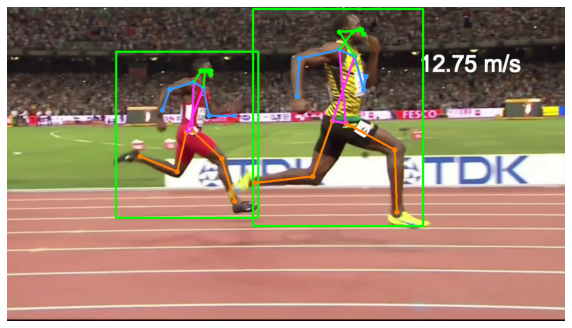

In [13]:
vis_result = vis_pose_result(
        model = pose_model,
        img = img,
        result = pose_results, kpt_score_thr=0,
        thickness=3, radius = 6
)

plt.figure(figsize=(10, 10))
plt.imshow(vis_result)
plt.axis('off')
plt.show()

#cv2.imwrite('visual_result/yolov3-273_dark-res50-192_3.jpg', img=cv2.cvtColor(vis_result, cv2.COLOR_BGR2RGB))

# Running on Video

In [14]:
import time
from IPython.display import clear_output

torch.backends.cudnn.benchmark = True

video_path = 'videos/500m-running-short.mp4'
out_video_path = 'visual_result/500m-running-short.mp4'
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

count = 0
n_frame_skip = 1

videoWriter = cv2.VideoWriter(out_video_path, fourcc, 22, size)

In [15]:
print(size, fps)

(854, 480) 29.97002997002997


In [16]:
FONT_SCALE = 0.8
FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_COLOR = (39, 0, 247)
FONT_THICKNESS = 2

## Top-Down Video

In [17]:
video_path = 'videos/500m-running-short.mp4'
cap = cv2.VideoCapture(video_path)
dataset = pose_model.cfg.data['test']['type']

while (cap.isOpened()):

    flag, img = cap.read()
    if not flag:
        break
    s1 = time.time()

    # test a single image, the resulting box is (x1, y1, x2, y2)
    mmdet_results = inference_detector(yolo_model, img)

    time_det = time.time()-s1
        
    # keep the person class bounding boxes.
    person_results = process_mmdet_results(mmdet_results)

    s2 = time.time()
    # test aq single image, with a list of bboxes.
    if len(person_results) == 0:
        vis_img = img
        time_pose = time.time() - s2
    else:
        pose_results, returned_outputs = inference_top_down_pose_model(
            pose_model,
            img,
            person_results,
            bbox_thr=0.3,
            format='xyxy',
            dataset=dataset,
            return_heatmap=False,
            outputs=None )
        time_pose = time.time() - s2
        
        # show the results
        vis_img = vis_pose_result(
            pose_model,
            img,
            pose_results,
            dataset=dataset,
            kpt_score_thr=0.3,
            thickness=2, radius = 5,
            show=False )

    fps_process = 1 / (time.time()-s1)
    
    cv2.putText(vis_img,f'Single Inference', (size[0]-250, 50),  FONT_FACE, FONT_SCALE, FONT_COLOR, FONT_THICKNESS)
    cv2.putText(vis_img,f'FPS {fps_process:.2f}', (15, 50),  FONT_FACE, FONT_SCALE, FONT_COLOR, FONT_THICKNESS)
    
    cv2.putText(vis_img,f'Detection {1/time_det:.2f}', (15, 75),  FONT_FACE, FONT_SCALE, FONT_COLOR, FONT_THICKNESS)
    cv2.putText(vis_img,f'Pose {1/time_pose:.2f}', (15, 100),  FONT_FACE, FONT_SCALE, FONT_COLOR, FONT_THICKNESS)
    
    cv2.imshow('Image', vis_img)
    
    #if save_out_video:
    videoWriter.write(vis_img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    # Frame Skipping
    #count += n_frame_skip
    #cap.set(1, count)

cap.release()
videoWriter.release()
    
cv2.destroyAllWindows()

## Bottom-Up Video

In [18]:
video_path = 'videos/tiki-taka.mp4'
cap = cv2.VideoCapture(video_path)
while (cap.isOpened()):
    flag, img = cap.read()
    if not flag:
        break
    s1 = time.time()

    # test aq single image, with a list of bboxes.
    pose_result, _ = inference_bottom_up_pose_model(model=udp_model, img_or_path=img)
    
    time_pose = time.time() - s2
    
    s3 = time.time()
    # show the results
    vis_img = vis_pose_result(
        udp_model,
        img,
        pose_result,
        dataset=dataset,
        kpt_score_thr=0.3,
        thickness=2, radius = 5,
        show=False )
    print(1 / (time.time()-s3))
    fps_process = 1 / (time.time()-s1)
    
    cv2.putText(vis_img,f'FPS {fps_process:.2f}', (15, 30),  FONT_FACE, 0.5, FONT_COLOR, FONT_THICKNESS)    
    cv2.imshow('Image', vis_img)
    
    #if save_out_video:
    #videoWriter.write(vis_img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    # Frame Skipping
    #count += n_frame_skip
    #cap.set(1, count)

cap.release()
#videoWriter.release()
    
cv2.destroyAllWindows()

NameError: name 'udp_model' is not defined

In [ ]:
print(type(f'{fps_process:.2f}'))